In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

In [2]:
random.seed(123)

# 1.誤差逆伝搬法の理解
ここのセクションでは，

$$
y = ax + b
$$

という関数について考えてみることにします．

## 1.1: 1変数の推定
まず，最も簡単なケースについて考えます．
ここで，
$
b = 2
$
であることが既知であり，
$
(x, y) = (2, 6) 
$
で式が成立することがわかっていたとします．

この時，
$$
6 = 2a + 2
$$
という関係式が成立し，$a=2$であることがわかります．まずは，この問題をあえて誤差逆伝搬法で解いてみましょう．

まずは，$ax + b$ をクラスで定義していきます．

In [3]:
class Linear:
    def __init__(self, a_init: float, b_init: float):
        self.a: float = a_init
        self.b: float = b_init
        
    def forward(self, x: float) -> float:
        return self.a * x + self.b 

早速作ったクラスが正しく機能しているか見てみましょう．

In [4]:
linear01 = Linear(a_init=2, b_init=2)
print("ax+b = 2x2+2 =", linear01.forward(2))
linear02 = Linear(a_init=4, b_init=1)
print("ax+b = 4x3+1 =", linear02.forward(3))

ax+b = 2x2+2 = 6
ax+b = 4x3+1 = 13


ここでは，Linearクラスとして実装を行いました．機械学習における各層は，基本的にクラスとして実装されます．これは，今回の場合，$a$が重み，$b$がバイアスと呼ばれるものであり，このLinear関数における内部変数として保存される必要があるためです．

では，続いて，どのように未知の値を推定していくか考えてみましょう．

今回の場合，$y=ax+b$という，きわめて簡単な式を用いていますので，簡単にできますが，あえて機械学習的に考えてみます．
「誤差逆伝搬法」というのは，あくまで「誤差」を定義し，これを逆向きにたどっていくことで，重みを修正していくわけです．
ですので，まずは，この「誤差」を定義します．


「誤差」は機械学習の世界においては「Loss」と言います．Loss関数というのを定め，学習を行います．
今回の場合は，$ax+b$が予測値，$y$が目標値のような関係です．そのため，今回のLoss関数は
$$
L(a,b)= y - (ax+b)
$$
と定義することとします．

今回は便宜上，重みは$a=2$で固定して，$b$を探索します．ですので，
$$
L(b) = y - Linear_{b}(x)
$$
となります．

ひとまず，bの初期値として，乱数で生成した値を使ってlossを計算してみましょう．

In [5]:
random.seed(123)
b_init = random.random()
b_init

0.052363598850944326

In [6]:
linear_b = Linear(a_init=2, b_init=b_init)

In [7]:
x, y = 2, 6
loss = y - linear_b.forward(x)
loss

1.9476364011490555

これでは，まだ $Linear_{b}(x)$ のほうが小さいということになります．では，どうすればよいでしょうか？ $b$を大きくしますか？小さくしますか？どれだけ大きくすればちょうどよいですか？

In [8]:
linear_b2 = Linear(a_init=2, b_init=b_init+loss)
loss2 = y - linear_b2.forward(x)
loss2

0.0

In [9]:
linear_b2.b

1.9999999999999998

これで，ほぼ正しく $b=2$を計算できましたね．ここでは，一気に答えに寄せに行きましたが，もう少し繰り返しを行って寄せていく方法もあります．

In [10]:
linear_b3 = Linear(a_init=2, b_init=b_init)
learning_rate = 0.5
for i in range(100):
    loss = y - linear_b3.forward(x)
    print(i, loss)
    linear_b3.b += loss * learning_rate

0 1.9476364011490555
1 0.9738182005745282
2 0.48690910028726364
3 0.24345455014363182
4 0.12172727507181591
5 0.060863637535907955
6 0.030431818767953978
7 0.015215909383977433
8 0.007607954691988716
9 0.003803977345993914
10 0.001901988672996957
11 0.0009509943364989226
12 0.0004754971682494613
13 0.00023774858412473066
14 0.00011887429206236533
15 5.9437146030738575e-05
16 2.9718573015813377e-05
17 1.4859286507906688e-05
18 7.429643253509255e-06
19 3.7148216271987167e-06
20 1.8574108135993583e-06
21 9.287054067996792e-07
22 4.643527029557504e-07
23 2.321763519219644e-07
24 1.1608817551689299e-07
25 5.8044087758446494e-08
26 2.9022044323312457e-08
27 1.4511021717567019e-08
28 7.255510858783509e-09
29 3.6277558734809645e-09
30 1.8138779367404823e-09
31 9.069385242810313e-10
32 4.5346926214051564e-10
33 2.2673507515946767e-10
34 1.1336709349052398e-10
35 5.668354674526199e-11
36 2.8341773372630996e-11
37 1.4170886686315498e-11
38 7.085887432367599e-12
39 3.5429437161837996e-12
40 1.7710

In [11]:
linear_b3.b

1.9999999999999998

こちらもほぼ誤差なく計算できましたね．
今回は厳密解のある計算でしたので，冗長に見えましたが，この，"loss"を計算して，それをパラメーター更新に用いるのが誤差逆伝搬法の考え方になります．

今回，誤差逆伝搬法において，パラメーターを更新していった方式を「最急降下法」といいます．これは，勾配の方向に最速で降下させていく方法です．

## 1.2 2変数の推定(OLS:最小二乗法)

先ほどは，1変数の推定でしたが，今度は2変数を推定することとします．
また，通常であれば，機械学習で使用するデータは1.1で確認したような完全に合致するようなケースは少なく，何らかの誤差を含みます．
そこで，ここでは誤差を含む複数のデータに基づく最小二乗法を考えます．

先ほどと同様の関数を用いますが，ここでは，以下のようにモデル化します．
$$
y=ax+b+\epsilon
$$
ここで，$\epsilon$は誤差項であり，正規分布を考えます．

ここでは，複数の$(x,y)$の組が与えられたときに，$a,b$を推測する問題になります．

まず，$(x,y)$の組を生成するにあたって，以下のように設定します．
$$
a = 2\\
b = 3\\
\epsilon \sim \mathscr{N}(0,1)
$$
とりあえず，$x$を$[0,5]$区間で設定して，データを生成します．

In [12]:
datasets = []
random.seed(100)
for _ in range(10):
    _x = random.random()*5
    _y = 2 * _x + 3 + random.normalvariate(0, 1)
    datasets.append((_x, _y))
datasets

[(0.7283462755206516, 4.119351746426455),
 (3.5275661346701397, 10.757589815010537),
 (4.000102285667139, 11.061566226050113),
 (2.279729405917836, 8.713412968186146),
 (1.5470296457001709, 6.67159349419088),
 (0.8923038147699563, 3.966494741349848),
 (3.1316081959639868, 11.023119082289234),
 (4.505760214936961, 12.66133369149357),
 (3.242714540602865, 8.694058443850727),
 (2.83078853646443, 9.592186652405658)]

In [13]:
X = np.array(list(map(lambda x: [x[0]], datasets)))
X = np.concatenate([np.ones_like(X), X], axis = -1)
Y = np.array(list(map(lambda x: [x[1]], datasets)))
X, Y

(array([[1.        , 0.72834628],
        [1.        , 3.52756613],
        [1.        , 4.00010229],
        [1.        , 2.27972941],
        [1.        , 1.54702965],
        [1.        , 0.89230381],
        [1.        , 3.1316082 ],
        [1.        , 4.50576021],
        [1.        , 3.24271454],
        [1.        , 2.83078854]]),
 array([[ 4.11935175],
        [10.75758982],
        [11.06156623],
        [ 8.71341297],
        [ 6.67159349],
        [ 3.96649474],
        [11.02311908],
        [12.66133369],
        [ 8.69405844],
        [ 9.59218665]]))

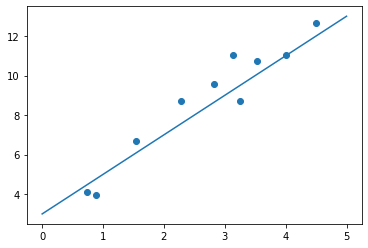

In [14]:
plt.scatter(X[:, 1], Y)
plt.plot([0, 5], [3,13] )
plt.show()

いい感じにデータが生成できたのではないでしょうか？
上記のコードで
 - datasets: $(x,y)$のタプルのリスト
 - X: $[1, x]$の行列
 - Y: $y$の行列

を生成してあります．

ここでは，$a,b$の2変数なので，毎回書いてもそこまで問題はないですが，層の数が多い場合などの表記が大変ですので，
$$
h_\theta(x) = X\theta^T   =  b + aX
$$
と定義し，$\theta = [[a,b]]$とします．


では，この設定に基づいて，$a, b$を推定していきましょう．

まずは，最小化したいコスト関数 (=Loss関数) $J$を設定します．ここでは，最小二乗法にしたいので，MSEを用います．
MSEとは，mean square errorの略であり，
$$
J=L_{MSE} = \frac{1}{N}\sum_{i=1}^N(t_i - p_i)^2
$$
で定義されます．ここで，$t$はターゲットの意味で，$p$が予測値です．

では，MSE Lossを関数で定義してみましょう．

In [15]:
def loss_MSE(inputs: np.ndarray, targets: np.ndarray) -> np.ndarray:
    if np.shape(inputs) != np.shape(targets):
        raise AssertionError
    if np.shape(inputs) != (len(inputs), 1):
        raise AssertionError
    return np.sum((targets - inputs) ** 2) / len(inputs)

In [16]:
## 両方Trueになれば正解
print(loss_MSE(inputs=np.array([[2], [3]]), targets=np.array([[2], [3]])) == 0.0)
print(loss_MSE(inputs=np.array([[3], [2]]), targets=np.array([[2], [3]])) == 1.0)

True
True


では，次に，この問題での誤差逆伝搬を考えてみましょう．

結局のところ，loss関数を最小化するのが目的でした．では，最小化するにあたって，何をいじるのか，と考えたときに，いじるのは$\theta$です．

つまり，loss関数の$\theta$における勾配を計算することになります．
では，計算していきましょう．

ここまでの設定にしたがって定式化をすると，
$$
L = \frac{1}{N}\sum_{i=1}^N(y_i - h_\theta(x_i))^2
$$
となります．ただし，ここで，$N$個のデータを考えるのはいささか煩雑なので，とりあえず，$N=1$で考えてみましょう．
$$
L = (y - h_\theta(x))^2
$$
深層学習においては，すべての層の勾配をいっぺんに伝播させるのではなく，「連鎖」をさせて計算をします．つまり，勾配の逆関数をそれぞれの層に対して定式化しておき，それらを連鎖させていくことで，勾配の計算，パラメーターの更新を行います．

まず，MSE Lossの勾配を考えます．MSE Lossの勾配だけを考えると，上記の式の$L$を$h_\theta(x)$で微分したものになるはずです．
つまり，
$$
\frac{\partial L}{\partial h_\theta(x)} = -2(y - h_\theta(x))
$$
となります．

続いて，線形の層($h_\theta(x)$)について考えます．こちらは，若干煩雑です．

今回は，$x$が入力になるので，$x$に対する勾配を考えてもどうしようもありませんが，とりあえず考えてみると，
$$
\frac{\partial h_\theta(x)}{\partial x} = a
$$
となります．$\because h_\theta(x) = ax+b$

では，次にこの線形の層の$a, b$に対する勾配を考えてみましょう．
$$
\frac{\partial h_\theta(x)}{\partial a} = x
$$
$$
\frac{\partial h_\theta(x)}{\partial b} = 1
$$
となりますね．

では，なぜこれらの各層ごとの勾配を計算しておくだけでうまくいくのかを見ていきます．
これは，$L$に対する$a, b$の勾配を計算するだけですぐにわかります．

$$
\frac{\partial L}{\partial a} = \frac{\partial L}{\partial h_\theta(x)}\cdot\frac{\partial h_\theta(x)}{\partial a} = -2(y - h_\theta(x))x
$$
$$
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial h_\theta(x)}\cdot\frac{\partial h_\theta(x)}{\partial b} = -2(y - h_\theta(x))
$$

しかし，深層学習においては，前述のとおりこの計算をいちいち行う必要はなく，今回の場合であれば，線形層がLoss関数から，勾配$-2(y - h_\theta(x))$を受け取りさえすれば充分なわけです．

今回は，$N=1$のケースで計算を行いましたが，実際には，$N$個のデータの勾配の平均を計算していきます．これをバッチ学習と言います．バッチ学習は，1つのデータセットに依存せずに複数の平均で勾配を計算しますので，学習が安定することなどのメリットがあるほか，GPUとの相性が良いため，標準的に使用されます．以下では，バッチ学習を前提として，実装を行います．

まず，今回は再急降下法の学習率$\alpha$は便宜上，グローバルに与えることとして，再急降下法のアルゴリズムおよびパラメーターの更新は各層の中の機能(updateという関数で，内部パラメーターを持つ層にのみ実装)に取り込む実装にしてしまいます．(実際には，多くの深層学習フレームワークは，勾配の伝搬だけを各層内のアルゴリズムに対して組み込み，パラメーター更新はoptimizerという形で，別の外部モジュールとして作成し，それが各層のパラメーターを更新していきます．)

In [17]:
class MSELoss:
    def __init__(self):
        self.grad: np.ndarray = None
        pass
    
    def forward(self, inputs: np.ndarray, targets: np.ndarray) -> np.ndarray:
        self.grad = -2 * (targets - inputs)
        return loss_MSE(inputs=inputs, targets=targets)
    
    def backward(self) -> np.ndarray:
        return self.grad

In [18]:
class Linear2:
    def __init__(self, alpha: float = 0.1):
        self.theta: np.ndarray = np.random.random([1,2])
        self.inputs: np.ndarray = None
        self.grad_theta: np.ndarray = None
        self.alpha: float = alpha
        
    def forward(self, inputs: np.ndarray) -> np.ndarray:
        ## inputs: N x 2 (X)
        ## outputs: N x 1
        if len(np.shape(inputs)) != 2:
            raise AssertionError("invalid dim")
        if np.shape(inputs)[1] != 2:
            raise AssertionError("invalid shape")
        self.inputs = inputs
        return np.matmul(inputs, self.theta.T)
    
    def backward(self, grad: np.ndarray) -> np.ndarray:
        # grad: 1x1
        self.grad_theta: np.ndarray  = np.mean(grad * self.inputs, axis=0)
        return grad * self.theta[0,0]
    
    def update(self):
        self.theta -= self.alpha * self.grad_theta

In [19]:
random.seed(123)
mse_layer = MSELoss()
linear_layer = Linear2()

In [20]:
## 学習
loss_list = []
for i in range(100):
    ## forward
    pred = linear_layer.forward(inputs=X)
    loss = mse_layer.forward(inputs=pred, targets=Y)
    ## backward
    _grad = mse_layer.backward()
    _grad = linear_layer.backward(grad=_grad)
    ## update
    linear_layer.update()
    loss_list.append(loss)
    print(i, loss)

0 46.27989611698857
1 36.74441943796331
2 29.209221366222387
3 23.25399920322466
4 18.546808363339274
5 14.825484626965098
6 11.882972624767968
7 9.555739203170129
8 7.714623024280553
9 6.2576081426575545
10 5.104117012274662
11 4.190503439919322
12 3.4664931781569317
13 2.892372902778635
14 2.436770216373728
15 2.074900406875087
16 1.7871818199743903
17 1.5581423400575907
18 1.3755557710422681
19 1.2297597785626293
20 1.1131172188616794
21 1.0195907065290455
22 0.9444066122367598
23 0.8837896877561537
24 0.8347534690486288
25 0.7949347304431578
26 0.7624627286370642
27 0.7358559225234147
28 0.7139403926726634
29 0.6957853987703223
30 0.680652472426068
31 0.6679552002167248
32 0.6572274500096873
33 0.6480982660221366
34 0.6402720311511907
35 0.6335127897463375
36 0.6276318566821305
37 0.6224780223519392
38 0.6179298083295599
39 0.6138893430585262
40 0.610277517444804
41 0.6070301517139675
42 0.6040949613502082
43 0.601429154521729
44 0.5989975286107286
45 0.5967709612771877
46 0.594725

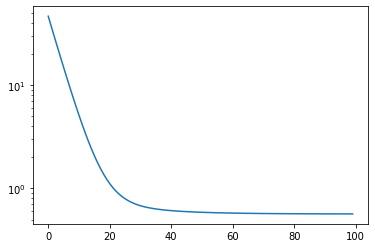

In [21]:
plt.plot(loss_list)
plt.yscale('log')
plt.show()

きれいに収束しましたでしょうか？今回はノイズを含んでいますので，0にはなりません．では，$a, b$の値を最後に確認してみましょう．

In [22]:
_a, _b = linear_layer.theta[0,1],linear_layer.theta[0,0] 
_a, _b

(2.2527654049427617, 2.7030557113390725)

あれ，おかしいですね．想定していた$a, b$にはならなかったのではないでしょうか？
ただ，この値に基づいてプロットしてみましょう．

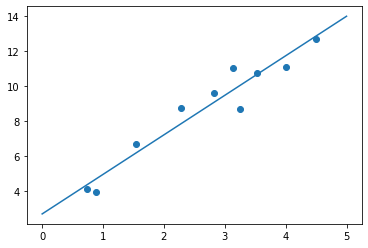

In [23]:
plt.scatter(X[:, 1], Y)
plt.plot([0, 5], [_b, 5 * _a + _b] )
plt.show()

どうやら，近似自体は正しそうですので，正しい実装ができていそうに見えますね．

では，どうすれば，$a, b$を想定の値に近づけることができるでしょうか -> **課題1** (答え(例): 10サンプルでなく，100サンプルにする)

これで本章の内容はおしまいです．再急降下法や逆伝搬法，各層の関係はなんとなくわかりましたでしょうか？
実際に実装する際には，pytorchなどを使えば，もっと簡単にこれらの実装を行うことができます．
また，誤差逆伝搬については，autogradといった，自動で勾配計算するツールが入っていますので，基本的には理論さえわかっていれば，実装ができます．

また，補足的事項として，今回はMSEを使用して，学習を行いました．そのため，実質的に，この操作は最小二乗法の近似的計算を行っていることになります．実際にはこの問題は最小二乗法の計算を行えば，解析的に最適な係数を割り出すことが可能です．もし，興味があれば，計算してみてください．(計算自体は高校生の統計の授業で扱われるレベルの簡単な計算です．)今回Loss関数に使用したMSEが実質的な対数尤度と相似であることも確認できます．

# 2. クラス分類問題と活性化関数

今度は2クラス分類問題を考えます．
$$
 y = ax + b
$$
を境界線と考え，サンプルがたくさんある状況を考えます．

とりあえず，ここでは，$a=-1, b=3$のケースを考えます．

境界線付近は分離があいまいであるという仮定で，データを生成します．(ここでは詳細を割愛します．)

In [24]:
X2 = []
T2 = []
random.seed(100)
for _ in range(1000):
    _x = random.random() * 3
    _y = random.random() * 3
    _diff = _y - (-1 * _x + 3)
    if _diff < -0.5:
        tag = 0
    elif _diff > 0.5:
        tag = 1
    else:
        if random.random() > _diff + 0.5:
            tag = 0
        else:
            tag = 1
    X2.append([_x, _y])
    T2.append([tag])
X2 = np.array(X2)
T2 = np.array(T2)

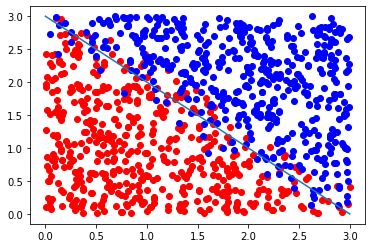

In [25]:
plt.scatter(X2[(T2 == 0).reshape(-1)][:, 0], X2[(T2 == 0).reshape(-1)][:, 1], c="red")
plt.scatter(X2[(T2 == 1).reshape(-1)][:, 0], X2[(T2 == 1).reshape(-1)][:, 1], c="blue")
plt.plot([0,3],[3,0])
plt.show()

上記では，
 - X2: (x,y)のデータ．Nx2の形
 - T2: クラス分類のタグ (Nx1)

として，データを格納しています
では，これを使って，$x, y$が与えられたらタグを返す分類機を作ります．
もちろん，$a, b$は最後まで未知とします．

2クラス分類においてはsigmoidが良く使われます．sigmoidとは，
$$
f(x) = \frac{1}{1 + e^{-x}}
$$
と定義されます．では，関数で定義して，見てみましょう．

In [26]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

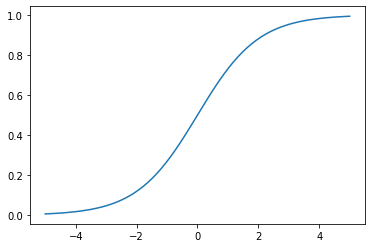

In [27]:
plt.plot(np.linspace(-5,5,200), sigmoid(np.linspace(-5,5,200)))
plt.show()

sigmoid関数は，0.5を境として，2クラス分類に使われます．これは，簡単に言えばタグが1になる確率を表してるともいえるので，0.5を超えているかどうかは分類自体には重要ですが，その確度の情報として数値自体も学習時には重要です．

このsigmoidは「活性化関数」といわれるものの一種で，最終層に使われるだけでなく，途中の層でも使われることがあります．

クラス分類のロス関数としては，交差エントロピー(cross entropy)が良く使われ，他クラス分類にも使用できる形で
$$
-\sum_{i=1}^{C}t_i log{y_i}
$$
と定義されます．ここでは，$t_i$はタグのone-hotベクトル，$y_i$が$i$クラス目に対応する出力値です．
なお，他クラス分類の場合には，活性化関数はsoftmaxが使用されますが，計算精度向上のために，実際にはLogSoftmax + Negative Log-likelihood Loss (NLL Loss)の組み合わせで実装されることが多いです．

**[課題]** LogSoftmaxとNLL Lossについて調べてみよう．なぜこの組み合わせだとSoftmaxとCross entropy Lossの組み合わせに対して計算精度が良くなるのか考えてみよう．

今回は2クラス分類に使用しますが，sigmoidの出力は1つであるため，このcross entropyを特殊に加工したbinary cross entropy lossを使用します．
$$
y = sigmoid(h_\theta(X))
$$
で出てきた出力に対して，
$$
L = -\sum_{i=1}^{2}t_i log{y_i} = -(1-t)\cdot log{(1-y)} - t\cdot log {y}
$$
と定義されます．ここで，tは0/1のクラス分類値であるとします．

なお，ここで，$h_\theta(X)$という前回とほぼ同じノーテーションを使ってしまいましたが，これはこれまで同様に線形層を指し示しているものの，入力の大きさがことなり，今回は，$x$だけでなく$y$も入力となるため，1次元大きくなります．また，従来はバイアス項に対応する1をXに追加していましたが，今回はこれを追加せずに実装したいと思います．

つまり，
$$
h_\theta(X) = [1,X] \theta^T = c + ax + by
$$
とし，$\theta = [[c, a, b]]$となります．
では，これを実装していきます．

まずはLinear層です．ちょっとだけ実装が変わりますね．classの継承でスマートに対応してしまいましょう．

In [28]:
class Linear3(Linear2):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.theta: np.ndarray = np.random.random([1,3])
        
    def forward(self, inputs: np.ndarray) -> np.ndarray:
        ## inputs: N x 2 (X)
        ## outputs: N x 1
        if len(np.shape(inputs)) != 2:
            raise AssertionError("invalid dim")
        if np.shape(inputs)[1] != 2:
            raise AssertionError("invalid shape")
        N = np.shape(inputs)[0]
        _inputs = np.concatenate([np.ones([N,1]), inputs], axis=1)
        self.inputs = _inputs
        return np.matmul(_inputs, self.theta.T)

続いて，sigmoidを作ってみましょう．逆伝搬を考えるために，微分を考えます．
$$
f(x) = \frac{1}{1 + e^{-x}}
$$
ですから，
$$
\frac{\partial f(x)}{\partial x} = \frac{e^{-x}}{(1 + e^{-x})^2} 
$$
となります．ただし，これでは計算の無駄がありますので，一度計算した$f(x)$を効率的に使って書き換えてみると，
$$
\frac{\partial f(x)}{\partial x} = f(x)\cdot (1 - f(x)) 
$$
となり，勾配の計算は順方向の計算結果を用いれば極めて簡単に出すことができるとわかります．

では，これを使ってsigmoid層を実装してみましょう．

In [29]:
class Sigmoid:
    def __init__(self):
        self.output = None
    
    def forward(self, inputs: np.ndarray) -> np.ndarray:
        self.output = sigmoid(inputs)
        return self.output
    
    def backward(self, grad: np.ndarray) -> np.ndarray:
        return grad * self.output * (1 - self.output)

最後に，Binary Cross Entropy (BCE) Lossを実装します．
$$
L = -(1-t)\cdot log{(1-y)} - t\cdot log {y}
$$
ですので，これも微分して，
$$
\frac{\partial L}{\partial y} = \frac{1-t}{1-y} - \frac{t}{y}
$$
とします．ただし，理論上sigmoidのアウトプットが完全に$0$にならないので，$1-y$と$y$は$0$にならないはずで，0割りが発生しないはずですが，実際には計算の桁落ちで$0$になってしまい，nanを出してしまうので，分母が0にならないように非常に小さな$\epsilon$を足しておきます．ただし，今回の後述の実験では，そのような問題は実質起きないので，インスタンス作成時に$\epsilon=0$としています．(ここでの$\epsilon$は冒頭でデータの生成に使用した$\epsilon$とは違うものですが，一般に$\epsilon$と表記することが多いので，あえて使っています．)

In [30]:
class BCELoss:
    def __init__(self, epsilon: float = 1e-10):
        self.grad: np.ndarray = None
        self.epsilon: float = epsilon
    
    def forward(self, inputs: np.ndarray, targets: np.ndarray) -> np.ndarray:
        self.grad = (1 - targets) / (1 - inputs + self.epsilon) - targets / (inputs + self.epsilon)
        return np.mean(- (1 - targets) * np.log(1 - inputs + self.epsilon) - targets * np.log(inputs+ self.epsilon))
    
    def backward(self) -> np.ndarray:
        return self.grad

では，これらを用いて学習をさせていきたいと思います．

また，今回は性能確認のために，データセットを9:1に分けて，10%の分をテストに使ってみましょう．

In [31]:
N_train = int(len(X2) * 0.9)
N_test = len(X2) - N_train
X2_train = X2[:N_train, :]
X2_test = X2[N_train:, :]
T2_train = T2[:N_train, :]
T2_test = T2[N_train:, :]

In [32]:
random.seed(123)
bce_loss_layer = BCELoss(epsilon=0)
sigmoid_layer = Sigmoid()
linear_layer3 = Linear3(alpha=1)

In [33]:
loss_list = []
for i in range(1000):
    ## forward
    _y = linear_layer3.forward(inputs=X2_train)
    _y = sigmoid_layer.forward(inputs=_y)
    loss = bce_loss_layer.forward(inputs=_y, targets=T2_train)
    ## backward
    _grad = bce_loss_layer.backward()
    _grad = sigmoid_layer.backward(grad=_grad)
    _grad = linear_layer3.backward(grad=_grad)
    ## update
    linear_layer3.update()
    loss_list.append(loss)
    print(i, loss)

0 0.778019901443709
1 0.614890167209569
2 0.5956866876010165
3 0.5787684992740166
4 0.5636144652033799
5 0.5498768670653426
6 0.5372984819749006
7 0.5256862261993569
8 0.5148939880454744
9 0.5048098689581675
10 0.49534678148709066
11 0.48643565152567364
12 0.4780205650437348
13 0.4700553273372763
14 0.46250102805709903
15 0.4553243141812539
16 0.4484961578029356
17 0.4419909687197805
18 0.435785947269202
19 0.42986060499712514
20 0.42419640317826585
21 0.4187764747309533
22 0.41358540575610825
23 0.40860906026200294
24 0.40383443665834584
25 0.39924954804170876
26 0.39484332065067046
27 0.39060550648724834
28 0.3865266072162614
29 0.3825978072264214
30 0.3788109142751683
31 0.37515830651764176
32 0.3716328849890178
33 0.3682280308029638
34 0.3649375664703963
35 0.36175572084792307
36 0.3586770973050922
37 0.3556966447612645
38 0.3528096312916376
39 0.3500116200411882
40 0.3472984472175082
41 0.3446662019603934
42 0.34211120790880856
43 0.33963000630538875
44 0.33721934049555186
45 0.33

781 0.16858095198663048
782 0.1685541942948475
783 0.16852750001064812
784 0.16850086891858068
785 0.16847430080417755
786 0.16844779545394936
787 0.16842135265537977
788 0.16839497219691932
789 0.16836865386798017
790 0.16834239745893043
791 0.16831620276108872
792 0.16829006956671877
793 0.16826399766902378
794 0.16823798686214125
795 0.16821203694113762
796 0.16818614770200277
797 0.16816031894164482
798 0.1681345504578852
799 0.16810884204945278
800 0.16808319351597942
801 0.16805760465799444
802 0.1680320752769196
803 0.16800660517506394
804 0.1679811941556191
805 0.1679558420226538
806 0.16793054858110937
807 0.1679053136367946
808 0.16788013699638088
809 0.16785501846739725
810 0.16782995785822583
811 0.16780495497809672
812 0.1677800096370835
813 0.16775512164609835
814 0.16773029081688753
815 0.16770551696202637
816 0.16768079989491505
817 0.1676561394297738
818 0.1676315353816383
819 0.16760698756635525
820 0.1675824958005778
821 0.1675580599017611
822 0.16753367968815774
823

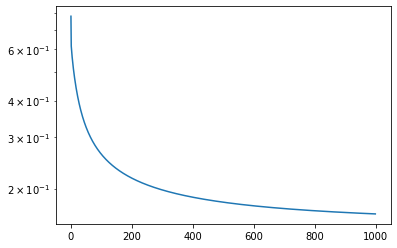

In [34]:
plt.plot(loss_list)
plt.yscale("log")
plt.show()

このcross entropyは非負実数であり，小さいほど良いものになります．正しく学習できていますでしょうか？

では，次にテストデータを使用して，性能を確認してみましょう．

In [35]:
## forwardのみ
_y = linear_layer3.forward(inputs=X2_test)
pred = sigmoid_layer.forward(inputs=_y)
pred > 0.5

array([[ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [

In [36]:
TP = ((T2_test == 1) & (pred > 0.5)).sum()
FN = ((T2_test == 1) & (pred <= 0.5)).sum()
TN = ((T2_test == 0) & (pred <= 0.5)).sum()
FP = ((T2_test == 0) & (pred > 0.5)).sum()
prec = (TP) / (TP + FP)
rec = (TP) / (TP + FN)
print("Acc:", (TP + TN) / len(T2_test))
print("Precision:", prec)
print("Recall:", rec)
print("F1:", 2/(1/prec + 1/rec))

Acc: 0.91
Precision: 0.9019607843137255
Recall: 0.92
F1: 0.9108910891089109


いかがでしたでしょうか？そこそこの精度が出ましたでしょうか？

# 3. 終わりに

第1章では回帰問題を，第2章では分類問題をフルスクラッチで実装しました．

ただ，今回扱ったのは単純な1つの線形層からなる判別機でしかありません．一般に，「深層学習」といった場合には，3層以上の層をもつものを言います．また，今回取り扱った活性化関数やロス関数もごくわずかなものですし，今回はパラメーター更新のアルゴリズムであるところのoptimizerに関しては再急降下法しか取り扱っていませんし，そのほかにも，Normalization, Grad clipなど，様々な学習の安定化方法もあります．きりがないほどたくさんありますが，それらを学び，適切なものを選択する能力が必要になります．

今回のように，勾配連鎖を実装することは極めてまれであり，基本的にはpytorchやtensorflowといったフレームワークがよきに計らってくれます．今回は，入門として，非常に簡単なものしか扱わないかわりに，フレームワークに依存することなく，numpyでフルスクラッチで実装してみました．しかし，今回取り上げた内容は深層学習の基礎であり，理論的背景を把握したうえでフレームワークを使用することは非常に有用です．特に勾配の連鎖に関しては，非常に重要な概念であり，今回の基礎が層が深くなっても適用可能です(実際にはフレームワークでは自分では実装しませんが．)．ぜひ，よい経験として，今回の内容をみなおし，今後の糧にしてもらえればと思います．

【課題】pytorchとtensorflowについて調べてみよう．今後機械学習を研究で使う可能性が高い場合には，どちらかを勉強してみよう．また，研究室のメンバーがどちらを使っているか聞いてみよう．